In [7]:
try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [8]:
print(tf.__version__)

1.15.0


In [9]:
# Function used to make this notebook's output stable across runs.
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Method to plot the Perceptron's decision boundary.
def plot_decision_boundary(classifier, X, y, title):    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    XX_ = np.c_[xx.ravel(), yy.ravel()]
        
    Z = classifier.predict(XX_)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(5, 5))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('$x_1$',fontsize=20)
    plt.ylabel('$x_2$',fontsize=20)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)    

    plt.show()
    
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot
    
class MyMLP():
    
    def __init__(self, filename):
        self.filename = filename

    def predict(self, X_):
        with tf.Session() as sess:
            saver.restore(sess, self.filename)
            res = sess.run(softmax, feed_dict={X : X_})
            Z = np.zeros((X_.shape[0]),)
            inc = 0
            for element in res:
                Z[inc] = np.argmax(element)
                inc += 1
        return Z

def createLogDir(root_logdir="./ex7_logs"):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)
    return logdir

In [10]:
logdir = createLogDir()

print('LOG dir: ',logdir)

LOG dir:  ./ex7_logs/run-20201204164918/


In [11]:
# Create 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X_, y_ = make_blobs(n_samples=1000, centers=centers, random_state=42)

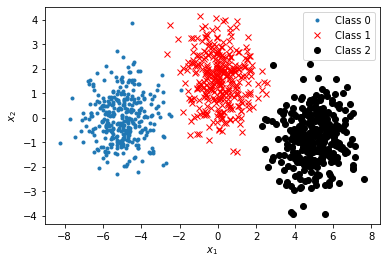

In [12]:
idx0 = np.argwhere(y_ == 0)
idx1 = np.argwhere(y_ == 1)
idx2 = np.argwhere(y_ == 2)

plt.plot(X_[idx0,0], X_[idx0,1], '.', label='Class 0')
plt.plot(X_[idx1,0], X_[idx1,1], 'rx', label='Class 1')
plt.plot(X_[idx2,0], X_[idx2,1], 'ko', label='Class 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [13]:
reset_graph()

learning_rate = 0.09
num_epoch = 10001

# Placeholders for input and output vectors.
X = tf.placeholder(tf.float32, shape=(None,2), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

# W matrix.
W = tf.Variable(tf.random_uniform([2,3], -1, 1), name='W')

# Bias vector.
b = tf.Variable(tf.random_uniform(shape=[3], minval=-1.0, maxval=1.0), name='b')

# Hidden layer and output layer.
with tf.name_scope('hidden'):
    logits = tf.matmul(X, W) + b
    softmax = tf.nn.softmax(logits)

# Error estimation
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

saver = tf.train.Saver()

loss_summary = tf.summary.scalar('loss', loss)

acc_summary = tf.summary.scalar('accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [14]:
sess = tf.Session()
sess.run(init)

loss_vec_gd = []
epoch_vec_gd = []
for i in range(0, num_epoch):
    error = sess.run(training_op, feed_dict={X: X_, y: y_})
    if(i % 100) == 0:
        loss_value = sess.run(loss, feed_dict={X: X_, y: y_})
        acc = sess.run(accuracy, feed_dict={X: X_, y: y_})
        print('Epoch: ' + str(i) + ' - Error: ' + str( loss_value ) + ' - Acc: ' + str(acc))
        loss_vec_gd.append(loss_value)
        epoch_vec_gd.append(i)
        save_path = saver.save(sess, logdir+'three_classes_model_gd_opt.ckpt')
    loss_str = sess.run(loss_summary, feed_dict={X: X_, y: y_})  
    file_writer.add_summary(loss_str, i)
    acc_str = sess.run(acc_summary, feed_dict={X: X_, y: y_})
    file_writer.add_summary(acc_str, i)
    
for el in sess.run(softmax, feed_dict={X: X_}):
    print('    ',el)
    
save_path = saver.save(sess, logdir+'three_classes_gd_optimizer_final.ckpt')
    
sess.close()
 
print ("Training Complete")

Epoch: 0 - Error: 0.51762724 - Acc: 0.789
Epoch: 100 - Error: 0.14271793 - Acc: 0.951
Epoch: 200 - Error: 0.10439058 - Acc: 0.966
Epoch: 300 - Error: 0.083793424 - Acc: 0.972
Epoch: 400 - Error: 0.07035554 - Acc: 0.981
Epoch: 500 - Error: 0.060847253 - Acc: 0.986
Epoch: 600 - Error: 0.053788513 - Acc: 0.987
Epoch: 700 - Error: 0.048366897 - Acc: 0.988
Epoch: 800 - Error: 0.04409027 - Acc: 0.992
Epoch: 900 - Error: 0.040641792 - Acc: 0.993
Epoch: 1000 - Error: 0.03780867 - Acc: 0.993
Epoch: 1100 - Error: 0.03544336 - Acc: 0.993
Epoch: 1200 - Error: 0.033440802 - Acc: 0.993
Epoch: 1300 - Error: 0.03172441 - Acc: 0.993
Epoch: 1400 - Error: 0.030237326 - Acc: 0.993
Epoch: 1500 - Error: 0.028936518 - Acc: 0.995
Epoch: 1600 - Error: 0.027788954 - Acc: 0.995
Epoch: 1700 - Error: 0.02676882 - Acc: 0.995
Epoch: 1800 - Error: 0.02585576 - Acc: 0.995
Epoch: 1900 - Error: 0.025033504 - Acc: 0.995
Epoch: 2000 - Error: 0.024288876 - Acc: 0.995
Epoch: 2100 - Error: 0.02361114 - Acc: 0.997
Epoch: 2200

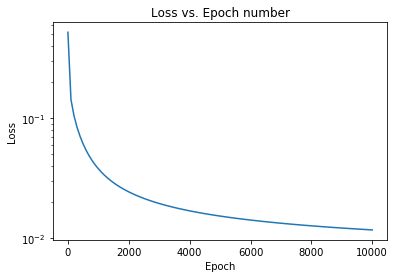

In [15]:
plt.plot(epoch_vec_gd, loss_vec_gd)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

In [16]:
# Calculate and return the accuracy on the test data
with tf.Session() as sess:
    saver.restore(sess, logdir+"three_classes_gd_optimizer_final.ckpt")
    acc = sess.run(accuracy, feed_dict={X: X_, y: y_})

print('Gradient Descent Optimizer accuracy: %1.4f' % (acc))

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201204164918/three_classes_gd_optimizer_final.ckpt
Gradient Descent Optimizer accuracy: 0.9980


INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201204164918/three_classes_gd_optimizer_final.ckpt


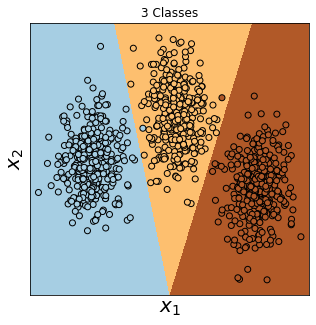

In [17]:
filenameGD = logdir+"three_classes_gd_optimizer_final.ckpt"

clf = MyMLP(filenameGD)

plot_decision_boundary(clf, X_, y_, '3 Classes')

In [18]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard

#taskkill /IM "tensorboard.exe" /F

In [19]:
%tensorboard --logdir './ex7_logs'

Reusing TensorBoard on port 6006 (pid 1436), started 6 days, 19:17:07 ago. (Use '!kill 1436' to kill it.)

In [20]:
reset_graph()

learning_rate = 0.09
num_epoch = 10001

# Placeholders for input and output vectors.
X = tf.placeholder(tf.float32, shape=(None,2), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

# W matrix.
W = tf.Variable(tf.random_uniform([2,3], -1, 1), name='W')

# Bias vector.
b = tf.Variable(tf.random_uniform(shape=[3], minval=-1.0, maxval=1.0), name='b')

# Hidden layer and output layer.
with tf.name_scope('hidden'):
    logits = tf.matmul(X, W) + b
    softmax = tf.nn.softmax(logits)

# Error estimation
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

saver = tf.train.Saver()

loss_summary = tf.summary.scalar('loss', loss)

acc_summary = tf.summary.scalar('accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [21]:
sess = tf.Session()
sess.run(init)

loss_vec_adam = []
epoch_vec_adam = []
for i in range(0, num_epoch):
    error = sess.run(training_op, feed_dict={X: X_, y: y_})
    if(i % 100) == 0:
        loss_value = sess.run(loss, feed_dict={X: X_, y: y_})
        acc = sess.run(accuracy, feed_dict={X: X_, y: y_})
        print('Epoch: ' + str(i) + ' - Error: ' + str( loss_value ) + ' - Acc: ' + str(acc))
        loss_vec_adam.append(loss_value)
        epoch_vec_adam.append(i)
        save_path = saver.save(sess, logdir+'three_classes_model_adam_opt.ckpt')
    loss_str = sess.run(loss_summary, feed_dict={X: X_, y: y_})  
    file_writer.add_summary(loss_str, i)
    acc_str = sess.run(acc_summary, feed_dict={X: X_, y: y_})
    file_writer.add_summary(acc_str, i)

for el in sess.run(softmax, feed_dict={X: X_}):
    print('    ',el)
    
save_path = saver.save(sess, logdir+'three_classes_adam_optimizer_final.ckpt')
    
sess.close()
 
print ("Training Complete")

Epoch: 0 - Error: 0.44060123 - Acc: 0.838
Epoch: 100 - Error: 0.020632507 - Acc: 0.998
Epoch: 200 - Error: 0.0143439025 - Acc: 0.998
Epoch: 300 - Error: 0.011841252 - Acc: 0.998
Epoch: 400 - Error: 0.010479902 - Acc: 0.998
Epoch: 500 - Error: 0.009617359 - Acc: 0.998
Epoch: 600 - Error: 0.009019268 - Acc: 0.998
Epoch: 700 - Error: 0.008578989 - Acc: 0.998
Epoch: 800 - Error: 0.008240705 - Acc: 0.998
Epoch: 900 - Error: 0.007972213 - Acc: 0.998
Epoch: 1000 - Error: 0.007753558 - Acc: 0.998
Epoch: 1100 - Error: 0.0075716903 - Acc: 0.998
Epoch: 1200 - Error: 0.0074177133 - Acc: 0.998
Epoch: 1300 - Error: 0.0072853174 - Acc: 0.998
Epoch: 1400 - Error: 0.007169931 - Acc: 0.998
Epoch: 1500 - Error: 0.007068148 - Acc: 0.998
Epoch: 1600 - Error: 0.0069773784 - Acc: 0.998
Epoch: 1700 - Error: 0.006895626 - Acc: 0.998
Epoch: 1800 - Error: 0.00682133 - Acc: 0.998
Epoch: 1900 - Error: 0.0067532426 - Acc: 0.998
Epoch: 2000 - Error: 0.006690366 - Acc: 0.998
Epoch: 2100 - Error: 0.0066319066 - Acc: 0

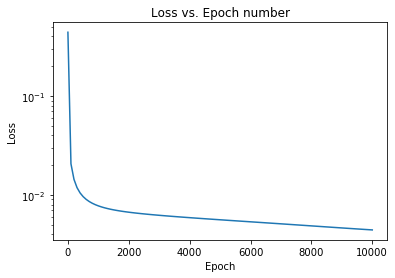

In [22]:
plt.plot(epoch_vec_adam, loss_vec_adam)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

In [23]:
# Calculate and return the accuracy on the test data
with tf.Session() as sess:
    saver.restore(sess, logdir+"three_classes_adam_optimizer_final.ckpt")
    acc = sess.run(accuracy, feed_dict={X: X_, y: y_})

print('Adam Optimizer accuracy: %1.4f' % (acc))

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201204164918/three_classes_adam_optimizer_final.ckpt
Adam Optimizer accuracy: 0.9990


INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201204164918/three_classes_adam_optimizer_final.ckpt


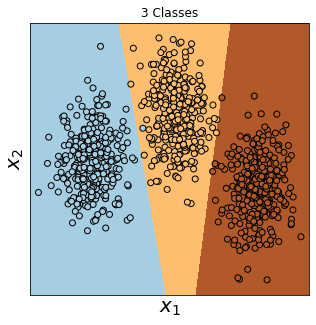

In [24]:
filenameAdam = logdir+"three_classes_adam_optimizer_final.ckpt"

clf = MyMLP(filenameAdam)

plot_decision_boundary(clf, X_, y_, '3 Classes')